# Confidence scores figure

Last edited June 29, 2021.

In [1]:
suppressPackageStartupMessages({
    library(symphony)
    library(singlecellmethods)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(Matrix)
    library(plyr)
    library(dplyr)
    library(Seurat)
    
    # Plotting
    library(ggplot2)
    library(ggthemes)
    library(ggrastr)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

colors = c('Unseen in reference' = 'coral1', 'Seen in reference' = 'aquamarine4')
outdir = '/data/srlab2/jkang/symphony_reproducibility/confidence_score/'

# Build standard missing cell type reference datasets

In [2]:
# Read in full dataset
metadata = readRDS('/data/srlab2/jkang/symphony_reproducibility/data/Fig2_pbmcs/metadata_gold_filtered.rds')
exprs_norm = readRDS('/data/srlab2/jkang/symphony_reproducibility/data/Fig2_pbmcs/exprs_norm_gold_filtered.rds')

table(metadata$cell_type, metadata$donor)
query_dataset = '3pv1'

           
            3pv1 3pv2   5p
  B          589 1231 1174
  DC          78  255  181
  HSC         21   19   24
  MK          30   63   55
  Mono_CD14  841 1822 2227
  Mono_CD16  352  242  373
  NK         291  322  303
  T_CD4     1657 2524 2135
  T_CD8      899 1827 1036

In [3]:
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')
    
    # Determine which indices to use
    idx_ref = which(metadata$donor != query_dataset & metadata$cell_type_broad != c)
    idx_query = which(metadata$donor == query_dataset)

    # Subset reference exprs and metadata
    exprs_norm_ref = exprs_norm[, idx_ref]
    metadata_ref = metadata[idx_ref,]

    # Subset query exprs and metadata
    exprs_norm_query = exprs_norm[, idx_query]
    metadata_query = metadata[idx_query,]
    
    # Save datasets
    saveRDS(exprs_norm_ref, paste0('./pbmc_missing_datasets/', 'reference_exp_norm_', filename_label, '.rds'))
    saveRDS(metadata_ref, paste0('./pbmc_missing_datasets/', 'reference_metadata_', filename_label, '.rds'))
    saveRDS(exprs_norm_query, paste0('./pbmc_missing_datasets/', 'query_exp_norm_', filename_label, '.rds'))
    saveRDS(metadata_query, paste0('./pbmc_missing_datasets/', 'query_metadata_', filename_label, '.rds'))
}

B

Mono

T

DC

NK

MK

HSC



# Make Symphony references and queries

In [5]:
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')
    
    # Build reference
    exprs_norm_ref = readRDS(paste0('./pbmc_missing_datasets/', 'reference_exp_norm_', filename_label, '.rds'))
    metadata_ref = readRDS(paste0('./pbmc_missing_datasets/', 'reference_metadata_', filename_label, '.rds'))
    exprs_norm_query = readRDS(paste0('./pbmc_missing_datasets/', 'query_exp_norm_', filename_label, '.rds'))
    metadata_query = readRDS(paste0('./pbmc_missing_datasets/', 'query_metadata_', filename_label, '.rds'))
    
    reference = symphony::buildReference(exp_ref = exprs_norm_ref, metadata_ref = metadata_ref, 
                    vars = 'donor', K = 100, verbose = FALSE, do_umap = TRUE, do_normalize = FALSE, 
                    vargenes_method = 'vst', vargenes_groups = 'donor', 'topn' = 1000, theta = 2,
                    save_uwot_path = paste0(outdir, 'results_pbmcs/ref_', filename_label, '_uwot_model'))
    
    # Map query
    query = mapQuery(exp_query = exprs_norm_query, metadata_query = metadata_query,
                        ref_obj = reference, vars = 'donor', do_normalize = FALSE, do_umap = TRUE, verbose = FALSE)
    
    # Add metadata variable specifying novel cell type
    query$meta_data$missing_in_reference = 'Seen in reference'
    query$meta_data$missing_in_reference[which(query$meta_data$cell_type_broad == c)] = 'Unseen in reference'
    
    saveRDS(reference, paste0('./results_pbmcs/ref_', filename_label, '.rds'))
    saveRDS(query, paste0('./results_pbmcs/query_', filename_label, '.rds'))
}

B

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Mono

Warning message:
“invalid uid value replaced by that for user 'nobody'”
T

Warning message:
“invalid uid value replaced by that for user 'nobody'”
DC

Warning message:
“invalid uid value replaced by that for user 'nobody'”
NK

Warning message:
“invalid uid value replaced by that for user 'nobody'”
MK

Warning message:
“invalid uid value replaced by that for user 'nobody'”
HSC

Warning message:
“invalid uid value replaced by that for user 'nobody'”


# Calculate and plot Symphony per-cluster mapping metric

In [3]:
## Plot results
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                            query_cluster_labels = query$meta_data$cell_type_broad, u = 1.5)
        # default u = 2, but force set to 1.5 to allow calculation for megakaryocytes (MK)
        
    per_cluster_metric$seen_in_reference = 'Seen in reference'
    per_cluster_metric$seen_in_reference[which(per_cluster_metric$query_cluster == c)] = 'Unseen in reference'

    # Plot per-cluster score
    fig.size(3.5, 4)
    pdf(paste0('figs_pbmcs/per-cluster_barplots/', filename_label, '_per_cluster.pdf'), 
        width = 4, height = 3.5, useDingbats = FALSE)
    p = ggplot(per_cluster_metric) +
        theme_bw() + theme(legend.position = 'none') + 
        geom_bar(aes(x = query_cluster, y = distance_score, 
                     fill = seen_in_reference), stat = 'identity') +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
        scale_fill_manual(values = colors) + ylim(0, 22) +
        ggtitle(paste0('Symphony (per-cluster): Ref missing ', c)) + theme(plot.title = element_text(hjust = 0.5)) +
        xlab('Query cell type') + ylab('per-cluster mapping metric') + 
        theme(legend.title = element_blank())
    plot(p)
    dev.off()
    p
    
    # Save query
    query$per_cluster_metric = per_cluster_metric
    saveRDS(query, paste0('./results_pbmcs/query_', filename_label, '.rds'))
}

B

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Warning message:
“Removed 1 rows containing missing values (position_stack).”
Mono

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Warning message:
“Removed 1 rows containing missing values (position_stack).”
T

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Warning message:
“Removed 1 rows containing missing values (position_stack).”
DC

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Warning message:
“Removed 1 rows containing missing values (position_stack).”
NK

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Warning message:
“Removed 1 rows containing missing v

# Calculate and plot Symphony per-cell mapping metric

Z_corr

In [4]:
## Plot results
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    query$meta_data$per_cell_metric = calcPerCellMappingMetric(reference, query, Z_orig = FALSE)

    # Plot
    pdf(paste0('figs_pbmcs/per-cell_boxplots/', filename_label, '_per_cell_Z_corr.pdf'), width = 4, height = 3.5, useDingbats = FALSE)
    fig.size(3.5, 4)
        
    p = ggplot(query$meta_data, #aes(x=reorder(cell_type_broad, -per_cell_metric), y=per_cell_metric, 
                                aes(x=cell_type_broad, y=per_cell_metric, 
                                    fill = missing_in_reference)) +
            geom_boxplot(outlier.size = 0.1, size = 0.3) + ylab('per-cell mapping metric') + 
            xlab('Query cell type') + scale_fill_manual(values = colors) +
            theme_bw() + theme(legend.position = 'none') + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ylim(0, 24) +
            ggtitle(paste0('Symphony (per-cell): Ref missing ', c)) + theme(plot.title = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p
}

B

Mono

T

DC

NK

MK

HSC



Z_orig

In [5]:
## Plot results
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    query$meta_data$per_cell_metric = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)
    query$meta_data$missing_in_reference = 'Seen in reference'
    query$meta_data$missing_in_reference[which(query$meta_data$cell_type_broad == c)] = 'Unseen in reference'

    # Plot
    pdf(paste0('figs_pbmcs/per-cell_boxplots/', filename_label, '_per_cell_Z_orig.pdf'), width = 4, height = 3.5, useDingbats = FALSE)
    fig.size(3.5, 4)
        
    p = ggplot(query$meta_data, #aes(x=reorder(cell_type_broad, -per_cell_metric), y=per_cell_metric, 
                                aes(x=cell_type_broad, y=per_cell_metric, 
                                    fill = missing_in_reference)) +
            geom_boxplot(outlier.size = 0.1, size = 0.3) + ylab('per-cell mapping metric') + 
            xlab('Query cell type') + scale_fill_manual(values = colors) +
            theme_bw() + theme(legend.position = 'none') + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ylim(0, 24) +
            ggtitle(paste0('Symphony (per-cell): Ref missing ', c)) + theme(plot.title = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p    
}

B

Mono

T

DC

NK

MK

HSC



# Compare with Seurat mapping scores

## Run Seurat

In [7]:
query_dataset = '3pv1'

In [9]:
for (cell_type_missing in unique(metadata$cell_type_broad)) {
    message(cell_type_missing)
    filename_label = paste('query', query_dataset, 'missing', cell_type_missing, sep = '_')

    exp_ref = readRDS(paste0('./pbmc_missing_datasets/', 'reference_exp_norm_', filename_label, '.rds'))
    metadata_ref = readRDS(paste0('./pbmc_missing_datasets/', 'reference_metadata_', filename_label, '.rds'))
    exp_query = readRDS(paste0('./pbmc_missing_datasets/', 'query_exp_norm_', filename_label, '.rds'))
    metadata_query = readRDS(paste0('./pbmc_missing_datasets/', 'query_metadata_', filename_label, '.rds'))
    rownames(metadata_ref) = metadata_ref$cell_id

    ## Build Seurat reference
    reference <- CreateSeuratObject(counts = exp_ref, project = paste0("no_", cell_type_missing), meta.data = metadata_ref)
    ref.list <- SplitObject(reference, split.by = "donor") # Splitting reference object

    for (i in 1:length(ref.list)) { # Finding reference variable features...
        # Data already normalized
        ref.list[[i]] = FindVariableFeatures(ref.list[[i]], selection.method = "vst", nfeatures = 1000)
    }

    # Identify anchors using the FindIntegrationAnchors function, which takes a list of Seurat objects as input.
    set.seed(0)
    ref.anchors <- FindIntegrationAnchors(object.list = ref.list, dims = 1:20, verbose = FALSE)

    # Integrating reference data
    ref.integrated <- IntegrateData(anchorset = ref.anchors, dims = 1:20, verbose = FALSE) # default is 30, but use 20 to compare with Symphony
    DefaultAssay(ref.integrated) <- "integrated"

    ## PCA to get integrated embedding
    ref.integrated <- ScaleData(ref.integrated, verbose = FALSE)
    ref.integrated <- RunPCA(ref.integrated, npcs = 20, verbose = FALSE)
    ref.integrated <- RunUMAP(ref.integrated, reduction = "pca", dims = 1:20, verbose = FALSE)
    
    # Save Seurat reference obj
    saveRDS(ref.integrated, paste0('./results_pbmcs/Seurat_ref_', filename_label, '.rds'))

    # Map query
    rownames(metadata_query) = metadata_query$cell_id
    set.seed(0)
    query <- CreateSeuratObject(counts = exp_query, project = "query", meta.data = metadata_query)
    query.anchors <- FindTransferAnchors(reference = ref.integrated, query = query, dims = 1:20, verbose = FALSE)
    query <- MapQuery(anchorset = query.anchors, query = query, reference = ref.integrated,
                  refdata = ref.integrated$cell_type_broad, reference.dims = 1:20, verbose = FALSE)
    
    # Calculate Seurat mapping score
    query@meta.data$mapping.scores = MappingScore(query.anchors, ndim = 20, verbose = FALSE)
    query@meta.data$missing_in_reference = 'Seen in reference'
    query@meta.data$missing_in_reference[which(query@meta.data$cell_type_broad == cell_type_missing)] = 'Unseen in reference'
    
    # Save Seurat query obj
    saveRDS(query, paste0('./results_pbmcs/Seurat_query_', filename_label, '.rds'))
}

B

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-1’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method

## Plot mapping scores

In [6]:
for (cell_type_missing in unique(metadata$cell_type_broad)) {
    message(cell_type_missing)
    filename_label = paste('query', query_dataset, 'missing', cell_type_missing, sep = '_')

    query = readRDS(paste0('./results_pbmcs/Seurat_query_', filename_label, '.rds'))

    # Plot
    fig.size(3.5, 4)
    pdf(paste0('figs_pbmcs/Seurat_mapping_scores/', filename_label, '_Seurat_mapping.pdf'), width = 4, height = 3.5, useDingbats = FALSE)
    p = ggplot(query@meta.data, #aes(x=reorder(cell_type_broad, mapping.scores), 
                               aes(x = cell_type_broad,
                                   y=mapping.scores, fill = missing_in_reference)) +
        geom_boxplot(outlier.size = 0.1, size = 0.3) + ylab('Seurat Mapping Score') + 
        xlab('Query cell type') + scale_fill_manual(values = colors) + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme_bw() + 
        ggtitle(paste0('Seurat: Ref missing ', cell_type_missing)) + theme(plot.title = element_text(hjust = 0.5)) +
        theme(legend.position = 'none') + ylim(0, 1) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    plot(p)
    dev.off()
    p
}

B

Mono

T

DC

NK

MK

HSC



# AUC plots separated by scenario

In [3]:
suppressPackageStartupMessages({
    library(pROC)
    library(ggplot2)  
})

In [4]:
## Plot results
listofrocs_Z_orig = list()
listofrocs_Z_corr = list()
listofrocs_per_cluster = list()
listofrocs_Seurat = list()

for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    query$meta_data$per_cell_metric_Z_orig = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)
    query$meta_data$per_cell_metric_Z_corr = calcPerCellMappingMetric(reference, query, Z_orig = FALSE)
    
    #----------- Symphony per-cell (Z_orig)
    # Plot
    pdf(paste0('figs_pbmcs/auroc/', filename_label, '_per_cell_Z_orig_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
    fig.size(4, 4)
    rocobj_Z_orig = roc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric_Z_orig, direction = '<')
    auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric_Z_orig, direction = '<'), 2)

    listofrocs_Z_orig[[paste0(c, ': AUC=', auc)]] = rocobj_Z_orig
    
    p = ggroc(rocobj_Z_orig, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Symphony: Ref missing ', c)) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p
    
    #------------ Symphony per-cell (Z_corr)
    
    # Plot
    pdf(paste0('figs_pbmcs/auroc/', filename_label, '_per_cell_Z_corr_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
    fig.size(4, 4)
    rocobj_Z_corr = roc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric_Z_corr, direction = '<')
    auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cell_metric_Z_corr, direction = '<'), 2)

    listofrocs_Z_corr[[paste0(c, ': AUC=', auc)]] = rocobj_Z_corr

    p = ggroc(rocobj_Z_corr, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Symphony: Ref missing ', c)) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p
    
    #---------- Symphony per-cluster
    
    per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                            query_cluster_labels = query$meta_data$cell_type_broad, u = 1.5)
    
    per_cluster_metric[is.na(per_cluster_metric)] = 0 
    colnames(per_cluster_metric) = c('cell_type_broad', 'per_cluster_metric')
    query$meta_data = merge(x = query$meta_data, y = per_cluster_metric, by = "cell_type_broad", all.x = TRUE)
    
    # Plot
    pdf(paste0('figs_pbmcs/auroc/', filename_label, '_per_cluster_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
    fig.size(4, 4)
    rocobj_percluster = roc(query$meta_data$missing_in_reference, query$meta_data$per_cluster_metric, direction = '<')
    auc = round(auc(query$meta_data$missing_in_reference, query$meta_data$per_cluster_metric, direction = '<'), 2)

    listofrocs_per_cluster[[paste0(c, ': AUC=', auc)]] = rocobj_percluster

    p = ggroc(rocobj_percluster, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Symphony: Ref missing ', c)) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p
    
    
    #---------- Seurat
    query = readRDS(paste0('./results_pbmcs/Seurat_query_', filename_label, '.rds'))
    
    # Plot
    pdf(paste0('figs_pbmcs/auroc/', filename_label, '_per_cell_Seurat_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
    fig.size(4, 4)
    rocobj_Seurat = roc(query@meta.data$missing_in_reference, query@meta.data$mapping.scores)
    auc = round(auc(query@meta.data$missing_in_reference, query@meta.data$mapping.scores), 2)

    listofrocs_Seurat[[paste0(c, ': AUC=', auc)]] = rocobj_Seurat
    
    p = ggroc(rocobj_Seurat, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Seurat: Ref missing ', c)) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
    plot(p)
    dev.off()
    p
}

B

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Calculating mapping confidence for 7 query clusters

(Warning) cluster contains too few cells to estimate confidence: HSC

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls > cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls > cases

Mono

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in reference

Setting levels: control = Seen in reference, case = Unseen in re

Plotting function obtained from: https://gist.github.com/charly06/91578196fc615c5a79c7174318be4349

In [5]:
ggrocs <- function(rocs, breaks = seq(0, 1, 0.2), legendTitel = "Unseen Cell Type") {
    require(plyr)
    # Store all sensitivities and specifivities in a data frame, which an be used in ggplot
    RocVals <- plyr::ldply(names(rocs), function(rocName) {
      data.frame(
        fpr = rev(rocs[[rocName]]$specificities),
        tpr = rev(rocs[[rocName]]$sensitivities),
        names = rep(rocName, length(rocs[[rocName]]$sensitivities)),
        stringAsFactors = T
      )
    })
    
    aucAvg <- mean(sapply(rocs, "[[", "auc"))

    rocPlot <- ggplot(RocVals, aes(x = fpr, y = tpr, colour = names)) +
      geom_segment(aes(x = 0, y = 1, xend = 1,yend = 0), alpha = 0.5, colour = "gray") + 
      geom_step() +
      scale_x_reverse(name = "Specificity",limits = c(1,0), breaks = breaks) + 
      scale_y_continuous(name = "Sensitivity", limits = c(0,1), breaks = breaks) +
      theme_classic() + 
      coord_equal() + 
      annotate("text", x = 0.1, y = 0.1, vjust = 0, label = paste("Mean AUC =\n", sprintf("%.2f",aucAvg))) +
      guides(colour = guide_legend(legendTitel)) +
      theme(axis.ticks = element_line(color = "grey80"))
    
    return(rocPlot)
}

Plot Symphony per-cell ROCs

png 
  2

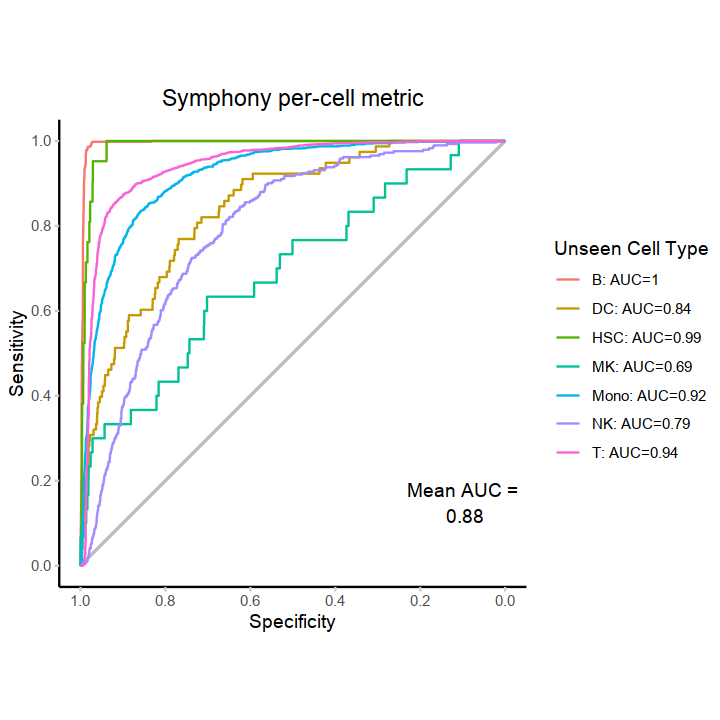

In [6]:
fig.size(6, 6)
pdf(paste0('figs_pbmcs/auroc/Symphony_per_cell_rocs.pdf'), width = 6, height = 6, useDingbats = FALSE)
rocs = ggrocs(listofrocs_Z_orig) + ggtitle('Symphony per-cell metric') + 
        theme(plot.title = element_text(hjust = 0.5))
plot(rocs)
dev.off()
rocs

Plot Symphony per-cluster ROCs

png 
  2

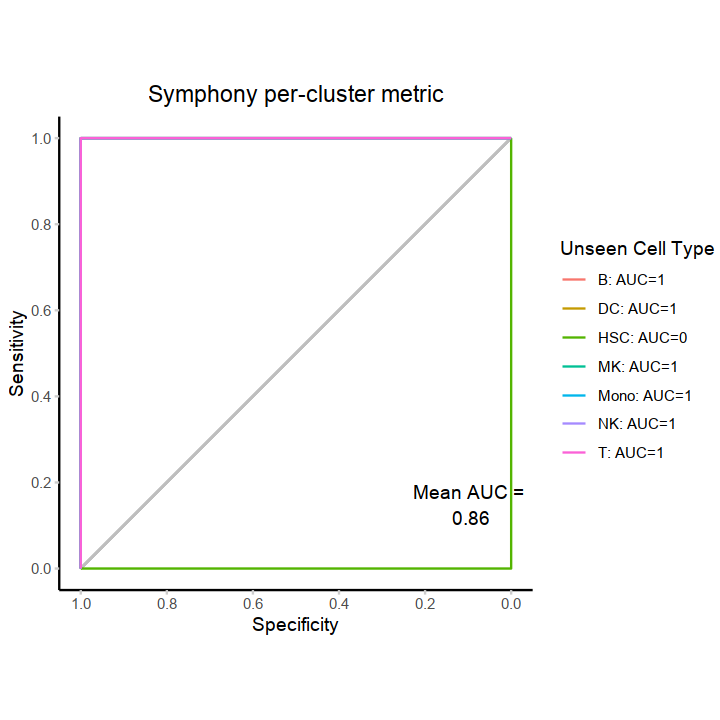

In [7]:
fig.size(6, 6)
pdf(paste0('figs_pbmcs/auroc/Symphony_per_cluster_rocs.pdf'), width = 6, height = 6, useDingbats = FALSE)
rocs = ggrocs(listofrocs_per_cluster) + ggtitle('Symphony per-cluster metric') + 
        theme(plot.title = element_text(hjust = 0.5))
plot(rocs)
dev.off()
rocs

Plot Seurat ROCs

png 
  2

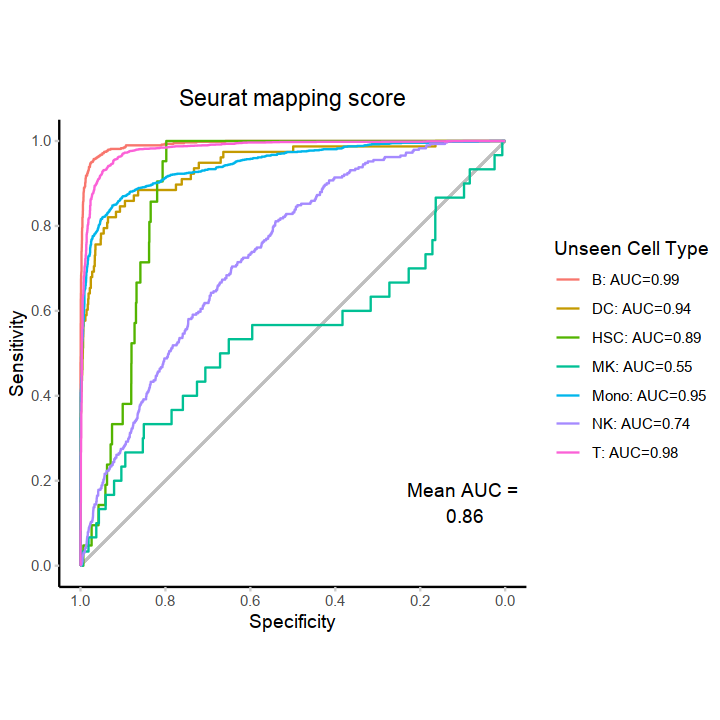

In [8]:
fig.size(6, 6)
pdf(paste0('figs_pbmcs/auroc/Seurat_rocs.pdf'), width = 6, height = 6, useDingbats = FALSE)
rocs = ggrocs(listofrocs_Seurat) + ggtitle('Seurat mapping score') + 
        theme(plot.title = element_text(hjust = 0.5))
plot(rocs)
dev.off()
rocs

# AUC plots aggregated across all scenarios

In [9]:
listofcombinedrocs = list()

In [10]:
aggregated_per_cell_Symphony = NULL
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    query$meta_data$per_cell_metric_Symphony = calcPerCellMappingMetric(reference, query, Z_orig = TRUE)
    aggregated_per_cell_Symphony = rbind(aggregated_per_cell_Symphony, query$meta_data)
}

B

Mono

T

DC

NK

MK

HSC



Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

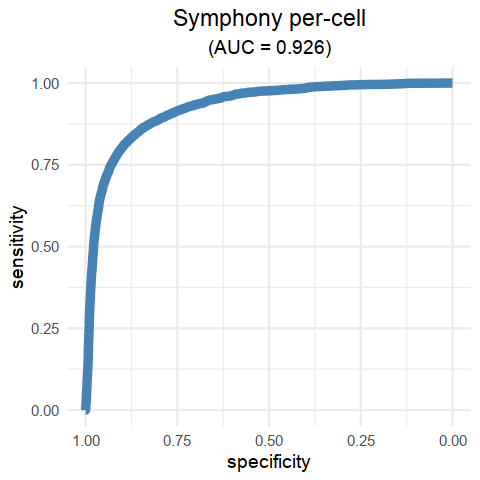

In [11]:
# Plot
pdf(paste0('figs_pbmcs/auroc/', 'Symphony_per_cell_combined_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
fig.size(4, 4)
rocobj = roc(aggregated_per_cell_Symphony$missing_in_reference, aggregated_per_cell_Symphony$per_cell_metric_Symphony)
auc = round(auc(aggregated_per_cell_Symphony$missing_in_reference, aggregated_per_cell_Symphony$per_cell_metric_Symphony), 3)
    
listofcombinedrocs[[paste0('Symphony_per-cell', ': AUC=', auc)]] = rocobj

p_sym_percell = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Symphony per-cell')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
plot(p_sym_percell)
dev.off()
p_sym_percell

In [12]:
aggregated_per_cluster_Symphony = NULL
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    suppressMessages({
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/query_', filename_label, '.rds'))
    reference = readRDS(paste0('./results_pbmcs/ref_', filename_label, '.rds'))
        
    per_cluster_metric = calcPerClusterMappingMetric(reference = reference, query = query, 
                            query_cluster_labels = query$meta_data$cell_type_broad, u = 1.5)
    
    per_cluster_metric[is.na(per_cluster_metric)] = 0 
    
    colnames(per_cluster_metric) = c('cell_type_broad', 'per_cluster_metric')
    aggregated_per_cluster_Symphony = rbind(aggregated_per_cluster_Symphony,
                            merge(x = query$meta_data, y = per_cluster_metric, by = "cell_type_broad", all.x = TRUE))
    
    })
}

B

Mono

T

DC

NK

MK

HSC



Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls < cases



png 
  2

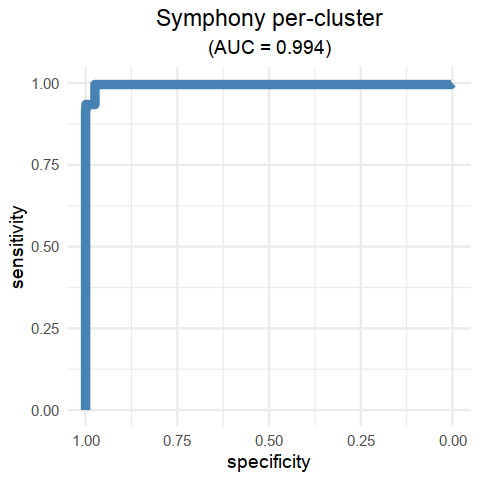

In [13]:
# Plot
pdf(paste0('figs_pbmcs/auroc/', 'Symphony_per_cluster_combined_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
fig.size(4, 4)
rocobj = roc(aggregated_per_cluster_Symphony$missing_in_reference, aggregated_per_cluster_Symphony$per_cluster_metric)
auc = round(auc(aggregated_per_cluster_Symphony$missing_in_reference, aggregated_per_cluster_Symphony$per_cluster_metric), 3)

listofcombinedrocs[[paste0('Symphony_per-cluster', ': AUC=', auc)]] = rocobj

p_sym_percluster = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Symphony per-cluster')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
plot(p_sym_percluster)
dev.off()
p_sym_percluster

In [14]:
aggregated_per_cell_Seurat = NULL
for (c in unique(metadata$cell_type_broad)) {
    message(c)
    filename_label = paste('query', query_dataset, 'missing', c, sep = '_')

    query = readRDS(paste0('./results_pbmcs/Seurat_query_', filename_label, '.rds'))
    aggregated_per_cell_Seurat = rbind(aggregated_per_cell_Seurat, query@meta.data)
}

B

Mono

T

DC

NK

MK

HSC



Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls > cases

Setting levels: control = Seen in reference, case = Unseen in reference

Setting direction: controls > cases



png 
  2

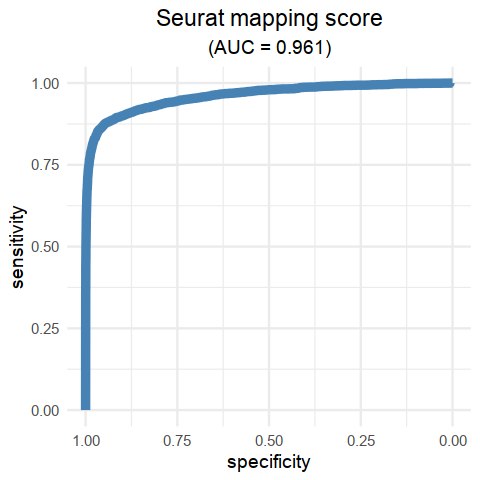

In [15]:
# Plot
pdf(paste0('figs_pbmcs/auroc/', 'Seurat_combined_auroc.pdf'), width = 4, height = 4, useDingbats = FALSE)
fig.size(4, 4)
rocobj = roc(aggregated_per_cell_Seurat$missing_in_reference, aggregated_per_cell_Seurat$mapping.score)
auc = round(auc(aggregated_per_cell_Seurat$missing_in_reference, aggregated_per_cell_Seurat$mapping.score), 3)
    
listofcombinedrocs[[paste0('Seurat_mapping_score', ': AUC=', auc)]] = rocobj

p_seurat = ggroc(rocobj, colour = 'steelblue', size = 2) +
        labs(subtitle = (paste0('(AUC = ', auc, ')'))) + ggtitle(paste0('Seurat mapping score')) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
plot(p_seurat)
dev.off()
p_seurat

In [16]:
fig.size(4, 12)
pdf(paste0('figs_pbmcs/auroc/', 'all_combined_aurocs.pdf'), width = 12, height = 4, useDingbats = FALSE)

p_sym_percell | p_sym_percluster | p_seurat

dev.off()

png 
  2

# All done!

In [17]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pROC_1.17.0.1           patchwork_1.1.1         RColorBrewer_1.1-2     
 [4] ggrastr_0.2.3           ggthemes_4.2.4          SeuratObject_4.0.1     
 [7] Seurat_4.0.2            plyr_1.8.6              Matrix_1.3-3           
[10] matrixStats_0.59.0      forcat